## Trabajo Fin de Máster <br/> Diseño de una arquitectura multimodal para descripción textual de pares imagen-audio

## Script 7. Detección de caras en una imagen y aplicación del modelo completo

En este notebook, hacemos uso de la librería FaceNet para detectar las caras que hay en una imagen con varias personas, y posteriormente aplicamos el modelo obtenido en el notebook 6 para discernir quién es dentro de nuestra base de datos.

### Paso 1. Montamos el almacenamiento

Damos permiso a Colab para acceder a mi unidad de Drive y nos situamos en la carpeta donde tenemos los scripts y la librería que hemos creado con las clases propias.

In [1]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(0)

In [2]:
import os
os.chdir('..')
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/tfm-cpu/code/Users/jose.puche/Scripts'

### Paso 2. Definición de parámetros y configuración

In [3]:
import clip
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset, SubsetRandomSampler, DataLoader

from tqdm import tqdm

from tfm_lib.audio_processing import AudioUtil, AudioAugmentation
from tfm_lib.datasets import CustomDataset
from tfm_lib.modelos import AudioCLIP
from tfm_lib.EarlyStopping import EarlyStopping

/anaconda/envs/jupyter_env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
folder_path = './../Final_Database'
num_epochs = 20
BATCH_SIZE = 16
data_augmentation = True
da = "_DA" if data_augmentation else ""
lr = 1e-4
output_dim = 40
selected_model = 'ViT-B/32'

model_parameters_file = f"./modelos/multimodal/FULL_{selected_model.replace('/','')}_{output_dim}pers_lr{f'{lr:.0e}'}_bs{BATCH_SIZE}_{num_epochs}ep{da}.pt"
print("Model:", model_parameters_file)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = AudioCLIP(selected_model, device, output_dim).to(device)
model.load_state_dict(torch.load(model_parameters_file, map_location=torch.device('cpu')))

Model: ./modelos/multimodal/FULL_ViT-B32_40pers_lr1e-04_bs16_20ep_DA.pt
Device: cpu


<All keys matched successfully>

In [5]:
classes = [ 'Alba Azorin Zafrilla', 'Alfonso Girona Palao', 'Alfonso Vidal Lopez', 'Ana Azorin Puche', 
            'Ana Puche Palao', 'Angela Espinosa Martinez', 'Clara Hidalgo Lopez', 'Cristina Carpena Ortiz',
            'David Azorin Soriano', 'Diego Molina Puche', 'Eva Jimenez Mariscal',
            'Francisco Jose Maldonado Montiel', 'Genesis Reyes Arteaga', 'Irene Gutierrez Perez', 
            'Irene Molina Puche', 'Irene Ponte Ibanez', 'Iria Alonso Alves', 'Javier Lopez Martinez',
            'Jonathan Gonzalez Lopez', 'Jorge Salinas Puche', 'Jose Alberto Azorin Puche', 'Jose Azorin Verdu',
            'Jose Duenas Garcia', 'Jose Manuel Nieto del Valle', 'Joseju Ubric Quesada', 'Juan Cuesta Lopez',
            'Juanjo Bautista Ibanez', 'Lydia Bautista Ibanez', 'Maria Jose Morales Forte', 'Mercedes Parody Guzman',
            'Miguel Correas Perez', 'Nerea Hernandez Carpintero', 'Noelia Sanchez Alonso', 'Oscar del Barrio Farran',
            'Rafael Molina Lopez', 'Regina SanMartino Miralles', 'Rodrigo Soriano Gonzalez', 'Rosi Puche Palao',
            'Sandra Castano Azorin', 'Sergio Castano Azorin']

### Paso 3. Lectura de los datos de prueba

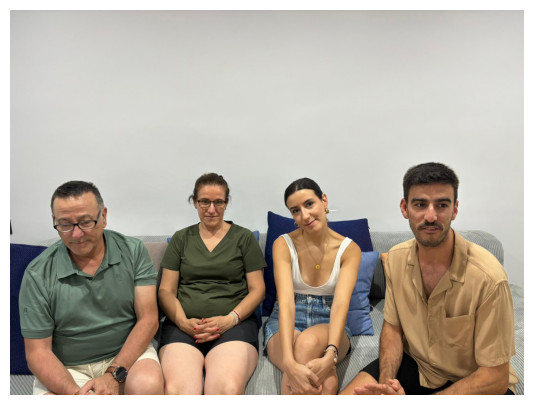

In [6]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

imagen_1 = Image.open('./../Test_images/video_prueba_1/imagen0001.jpeg')

plt.figure(figsize=(7, 5))
plt.imshow(imagen_1)
plt.axis('off');

### Paso 5. Detección de caras con FaceNet

In [7]:
import torch
from facenet_pytorch import MTCNN
import numpy as np

# Detectar si se dispone de GPU cuda
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            select_largest = True,
            min_face_size  = 20,
            thresholds     = [0.6, 0.7, 0.7],
            post_process   = False,
            image_size     = 224,
            device         = device
        )

Running on device: cpu


In [8]:
boxes, probs, landmarks = mtcnn.detect(imagen_1, landmarks=True)
print('Bounding boxes:', boxes)
print('Probability:', probs)
print('landmarks:', landmarks)

Bounding boxes: [[1578.4833984375 677.4862060546875 1770.8619384765625 930.8881225585938]
 [172.9417724609375 745.7743530273438 360.6465759277344 990.2681884765625]
 [1105.77490234375 713.033935546875 1257.0682373046875 889.0628662109375]
 [745.1231079101562 703.1034545898438 860.1558837890625 860.4542846679688]]
Probability: [0.9999293088912964 0.9992734789848328 0.9999728202819824
 0.9999997615814209]
landmarks: [[[1635.967041015625 779.6587524414062]
  [1725.4849853515625 780.6073608398438]
  [1678.5604248046875 833.88134765625]
  [1639.123779296875 875.458740234375]
  [1711.4188232421875 874.041015625]]

 [[228.601806640625 860.1607666015625]
  [309.76556396484375 845.0398559570312]
  [275.6623840332031 904.4893798828125]
  [248.36424255371094 941.9976196289062]
  [324.20269775390625 925.5166015625]]

 [[1140.5809326171875 802.52001953125]
  [1197.8681640625 775.1156616210938]
  [1174.29052734375 831.4388427734375]
  [1170.1343994140625 859.4378662109375]
  [1224.677978515625 834.8

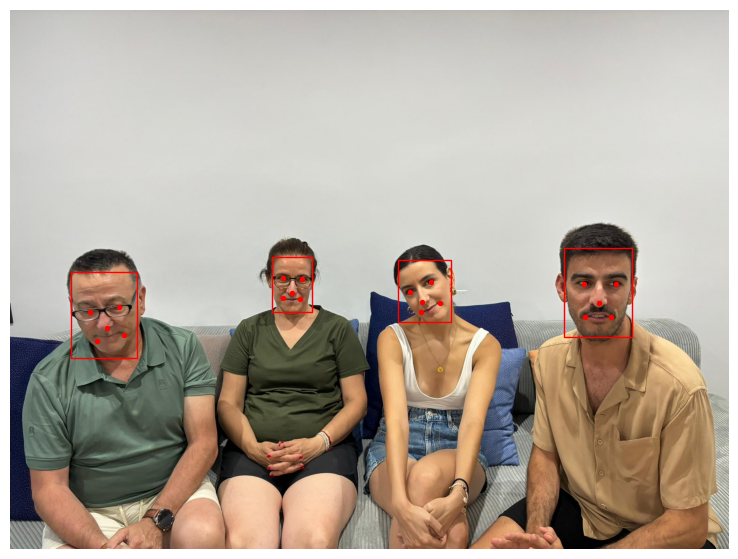

In [9]:
# Representación con matplotlib
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(imagen_1)

for box, landmark in zip(boxes, landmarks):
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
    rect = plt.Rectangle(
                xy     = (box[0], box[1]),
                width  = box[2] - box[0],
                height = box[3] - box[1],
                fill   = False,
                color  = 'red'
           )
    ax.add_patch(rect)

ax.axis('off');

In [10]:
# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = False,
            image_size    = 224,
            device        = device
        )

# Detección de caras
# ==============================================================================
faces = mtcnn.forward(imagen_1)

faces.shape

torch.Size([4, 3, 224, 224])

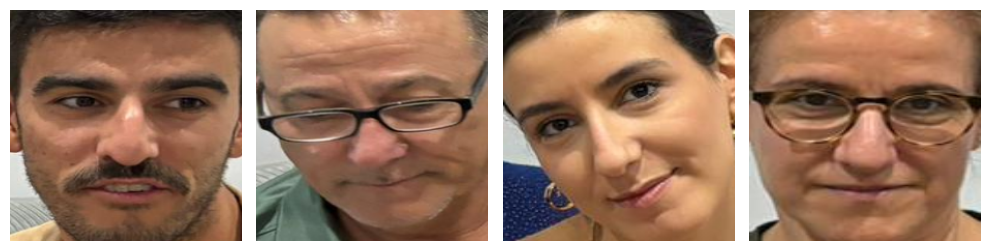

In [11]:
# Representación con matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))
axs= axs.flatten()

for i in range(faces.shape[0]):
    face = faces[i,:,:,:].permute(1, 2, 0).int().numpy()
    axs[i].axis('off')
    axs[i].imshow(face)

plt.tight_layout();

Prueba

In [16]:
import torchvision.transforms as T
transform = T.ToPILImage()

read_image = faces[0,:,:,:].type(torch.uint8)
aud = AudioUtil.open('./../Test_images/audios/Jose Alberto Azorin Puche.ogg')
aud = AudioUtil.resample(aud, 16000)
aud = AudioUtil.rechannel(aud, 1)
aud = AudioAugmentation.pad_trunc(aud, 4)
sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None).unsqueeze(0).to(device)

image = model.preprocess(transform(read_image)).unsqueeze(0).to(device)
text = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

with torch.no_grad():
  output = model(image, text, sgram)

pd.DataFrame(data = {'Persona': classes, 'Probabilidad': output.softmax(dim=-1)[0].tolist()}).sort_values('Probabilidad', ascending=False).head()

,Persona,Probabilidad
20,Jose Alberto Azorin Puche,0.983016
18,Jonathan Gonzalez Lopez,0.008520
25,Juan Cuesta Lopez,0.004401
13,Irene Gutierrez Perez,0.001430
6,Clara Hidalgo Lopez,0.000553


In [20]:
for name, par  in model.named_parameters():
    print(f'{name}: {par}')

clip_model.positional_embedding: Parameter containing:
tensor([[-1.3895e-03,  4.4673e-04, -3.9476e-03,  ..., -4.1861e-03,
         -3.4140e-03, -2.8880e-04],
        [ 5.4514e-04,  2.2793e-03,  1.1406e-03,  ..., -1.2058e-03,
          2.2206e-03,  5.9302e-04],
        [-2.2031e-04,  1.6853e-03,  3.5875e-04,  ...,  1.5235e-04,
         -5.7721e-03,  2.3740e-03],
        ...,
        [ 3.9403e-03,  4.3212e-03, -3.6539e-02,  ...,  2.2139e-03,
         -2.4105e-03, -5.3089e-03],
        [ 6.7252e-03,  3.6138e-03, -3.5063e-02,  ..., -2.9890e-03,
         -8.3040e-06, -4.3714e-03],
        [ 6.5732e-04,  1.2495e-02, -7.1374e-03,  ...,  1.8150e-02,
          4.6621e-04, -2.5021e-02]], requires_grad=True)
clip_model.text_projection: Parameter containing:
tensor([[-0.0105,  0.0141, -0.0084,  ..., -0.0069, -0.0125,  0.0013],
        [ 0.0053,  0.0015, -0.0037,  ...,  0.0030,  0.0137, -0.0204],
        [ 0.0027,  0.0031,  0.0183,  ...,  0.0033,  0.0052, -0.0063],
        ...,
        [ 0.0093,  0